# Introduction

This notebook applies classical statistical techniques to detect anomalies in machine temperature data. 
These methods are fast, interpretable, and serve as strong baselines for understanding time series behavior before applying machine learning or deep learning models.

The following techniques were applied and comparede:
- Z-score thresholding
- Rolling mean and standard deviation
- Interquartile Range (IQR)
- Median Absolute Deviation (MAD)
- Percent change detection
- Cumulative Sum (CUSUM) with reset logic


## 1. Import modules and load data

In [197]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [198]:
# load data
url = "https://raw.githubusercontent.com/hjalalin/nab-anomaly-detection/main/data/realKnownCause/machine_temperature_system_failure.csv"
df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

## Overview Classical Anomaly Detection Methods

Here’s a high-level comparison of the statistical techniques applied:

| Method                | Type        | Description                                                                  | Strengths                                        | Limitations                                      |
|-----------------------|-------------|-------------------------------------------------------------------------------|--------------------------------------------------|--------------------------------------------------|
| **Z-score**           | Global      | Detects anomalies based on values that fall beyond ±3 standard deviations from the overall mean | Simple, fast, and interpretable                    | Ignores time structure; sensitive to outliers and skew |
| **Rolling Mean ± 3σ** | Local       | Compares each point to a rolling mean ± 3×rolling standard deviation over a sliding window | Adapts to local behavior; good for short-term shifts | Needs window tuning; can lag during rapid changes |
| **IQR**               | Global      | Identifies values outside Q1 − 1.5×IQR or Q3 + 1.5×IQR                       | Robust to outliers and non-normal distributions    | Ignores local trends and temporal dependencies     |
| **MAD**               | Global      | Identifies points where deviation from median exceeds 3×MAD (Median Absolute Deviation) | Effective with skewed and noisy data               | Not sensitive to subtle changes or local drifts    |
| **Percent Change**    | Pointwise   | Marks points with a relative change > 5% compared to the previous point     | Good for detecting sudden spikes or drops          | Ignores baseline trend or seasonal changes       |
| **CUSUM (with reset)**| Sequential  | Accumulates deviations from the mean; detects shifts when cumulative sum exceeds a threshold (e.g., ±10), with optional resets | Good for detecting sustained shifts or drifts      | Sensitive to noise; requires smoothing and tuning  |





## Helper Functions for Anomaly Detection

To keep the workflow modular and organized, each anomaly detection method is implemented as a reusable function.  
These functions take in the time series data and return a boolean mask indicating detected anomalies.

### Methods Included:
- **Z-Score**: Based on standard deviation from the mean.
- **IQR**: Flags values outside the interquartile range.
- **MAD**: Uses robust median absolute deviation.
- **Rolling Mean**: Detects points that deviate from a moving average.
- **CUSUM**: Identifies gradual shifts using cumulative sum control.

These modular functions allow us to apply all methods consistently and make side-by-side comparisons easier.


In [199]:
def detect_zscore(df, column='value', threshold=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    return z_scores.abs() > threshold

def detect_iqr(df, column='value', k=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    return (df[column] < q1 - k * iqr) | (df[column] > q3 + k * iqr)

def detect_mad(df, column='value', threshold=3.5):
    median = df[column].median()
    mad = (np.abs(df[column] - median)).median()
    modified_z = 0.6745 * (df[column] - median) / mad
    return np.abs(modified_z) > threshold

def detect_rolling_mean(df, column='value', window=24, threshold=3):
    rolling_mean = df[column].rolling(window=window, center=True).mean()
    rolling_std = df[column].rolling(window=window, center=True).std()
    return np.abs(df[column] - rolling_mean) > threshold * rolling_std

def detect_cusum(df, column='value', window=10, drift=0.2, threshold=5):
    smoothed = df[column].rolling(window=window, center=True).mean()
    df_cusum = df.copy()
    df_cusum['smoothed'] = smoothed
    df_cusum = df_cusum.dropna(subset=['smoothed'])
    
    pos_cusum = np.zeros(len(df_cusum))
    neg_cusum = np.zeros(len(df_cusum))
    anomalies = []

    for i in range(1, len(df_cusum)):
        diff = df_cusum[column].iloc[i] - df_cusum['smoothed'].iloc[i]
        pos_cusum[i] = max(0, pos_cusum[i-1] + diff - drift)
        neg_cusum[i] = max(0, neg_cusum[i-1] - diff - drift)
        if pos_cusum[i] > threshold or neg_cusum[i] > threshold:
            anomalies.append(df_cusum.index[i])
            pos_cusum[i] = 0
            neg_cusum[i] = 0

    result = pd.Series(False, index=df.index)
    result.loc[anomalies] = True
    return result


In [212]:
df['anomaly_zscore'] = detect_zscore(df)
df['anomaly_iqr'] = detect_iqr(df)
df['anomaly_mad'] = detect_mad(df)
df['anomaly_rolling'] = detect_rolling_mean(df)
df['anomaly_cusum'] = detect_cusum(df)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


## Visual Comparison of Anomaly Detection Methods

Below are individual plots showing anomalies detected by each method.  
This layout allows us to compare the performace of diffrent methods and understand the differences in sensitivity, robustness, and context-awareness.


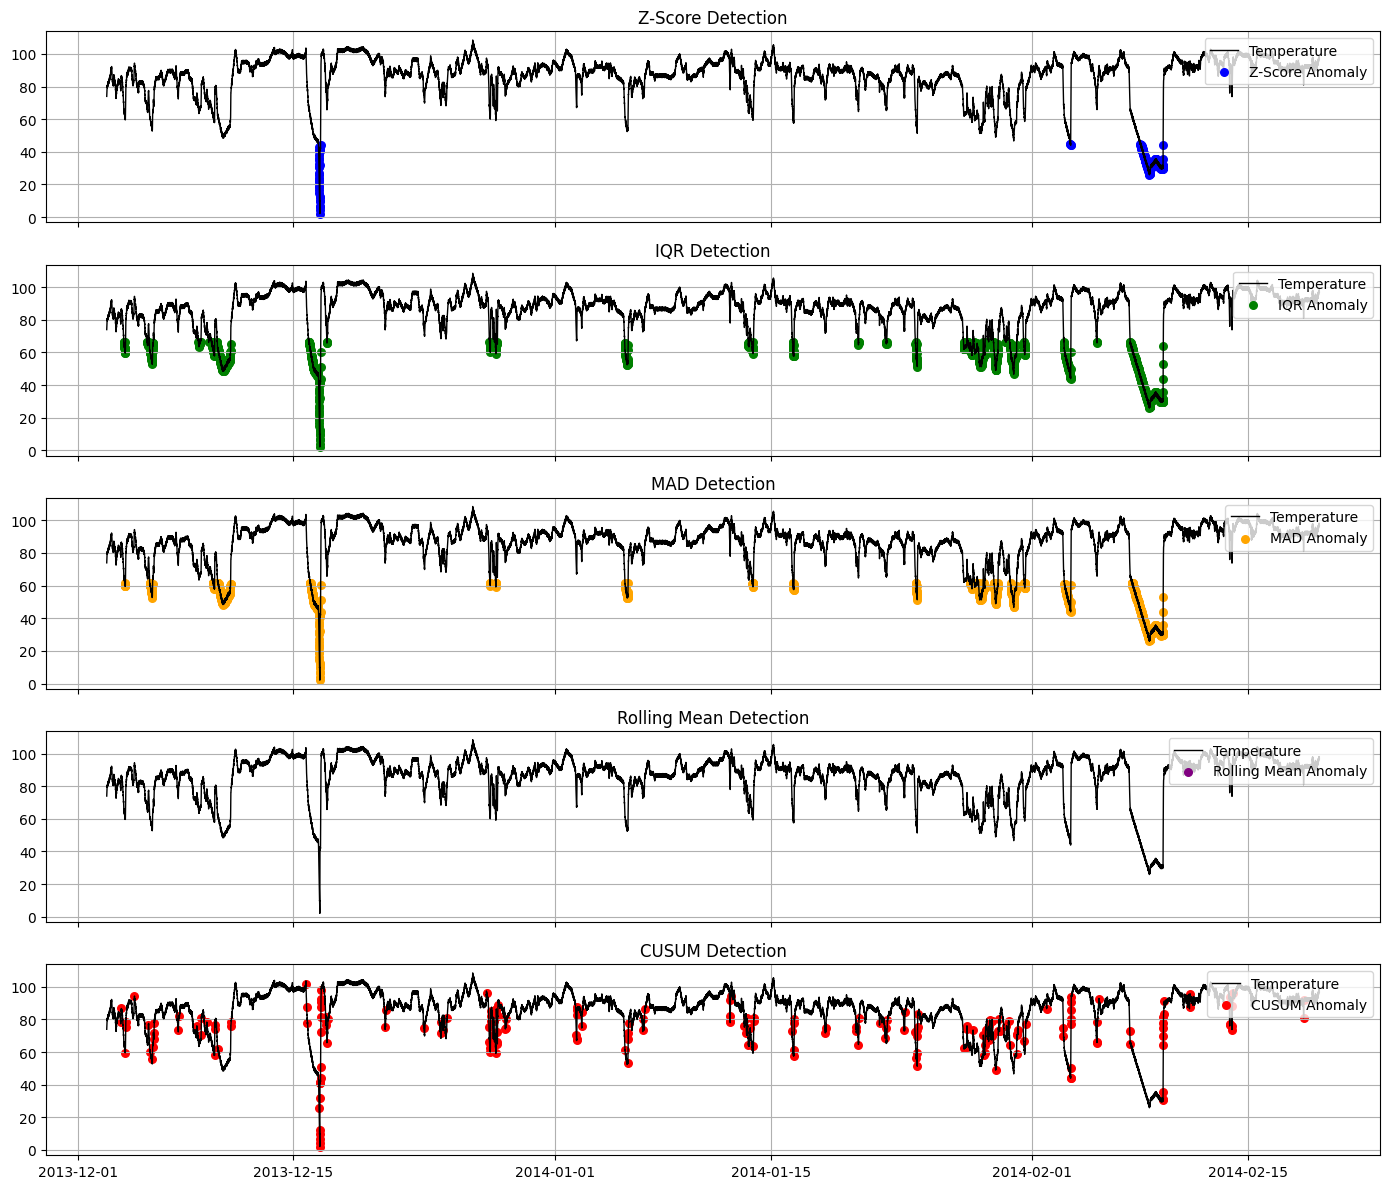

In [215]:
methods = [
    ('Z-Score', 'anomaly_zscore', 'blue'),
    ('IQR', 'anomaly_iqr', 'green'),
    ('MAD', 'anomaly_mad', 'orange'),
    ('Rolling Mean', 'anomaly_rolling', 'purple'),
    ('CUSUM', 'anomaly_cusum', 'red')
]

fig, axes = plt.subplots(len(methods), 1, figsize=(14, 12), sharex=True)

for i, (title, col, color) in enumerate(methods):
    ax = axes[i]
    ax.plot(df['value'], label='Temperature', color='black', linewidth=1)
    ax.scatter(df[df[col]].index, df[df[col]]['value'], color=color, s=30, label=f'{title} Anomaly')
    ax.set_title(f"{title} Detection")
    ax.legend(loc='upper right')
    ax.grid(True)

plt.tight_layout()
plt.show()


## Summary Table

In [214]:
summary = {
    method[0]: df[method[1]].sum() for method in methods
}
pd.DataFrame.from_dict(summary, orient='index', columns=['# Anomalies Detected'])


,# Anomalies Detected
Z-Score,462
IQR,2298
MAD,1748
Rolling Mean,0
CUSUM,210


## Discussion

The Z-score method successfully identified a few extreme temperature dips, notably the sharp drops in mid-December 2013 and early February 2014.

- Accurately detected large, isolated deviations.
- Failed to capture smaller fluctuations and gradual declines.

Overall, Z-score is effective for spotting abrupt anomalies but lacks sensitivity to context and slow-changing patterns in the data.

## Takeaways